# Exercise 3: Advanced Information Retrieval


## 1.  Introducing Word Embeddings

In this exercise, we would train word embeddings using a state-of-the-art embeddings library fastText. The first step of the exercise is to install the fastText library. Proceed with the following steps:

### FastText installation


#### Run these commands on the shell terminal:

> wget https://github.com/facebookresearch/fastText/archive/v0.1.0.zip <br>
> unzip v0.1.0.zip<br>
> cd fastText-0.1.0 <br>
> make<br>

<br>

(Use curl -O for mac, or just download and unzip manually by clicking on the link, then switch to the unzipped folder and use the make command.

Move the epfldocs.txt file (provided in the last exercise) to the current directory. Sample command (linux) for copying the file into current directory is as follows:

> cp directory_path/epfldocs.txt ./

(or just drag and drop the file)

<br>

### Generate Embeddings

Further, generate fasttext embeddings for the epfldocs.txt file using the following command:

> ./fasttext skipgram -input epfldocs.txt -output model_epfldocs


The above command generates word embeddings and stores them in a file named model_epfldocs.vec.

<br>

### Load Embeddings

In the second phase of this exercise, we will load these embeddings into memory using python and visualize them.
Use the following python code to load the embeddings into memory:<br><br>



In [7]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')




### Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities). t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [97]:
print((word_embeddings.shape))

(432, 100)


In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300) # init='pca'
vis_data = tsne.fit_transform(word_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.001s...
[t-SNE] Computed neighbors for 432 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.020536
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.340694
[t-SNE] Error after 300 iterations: 0.367600


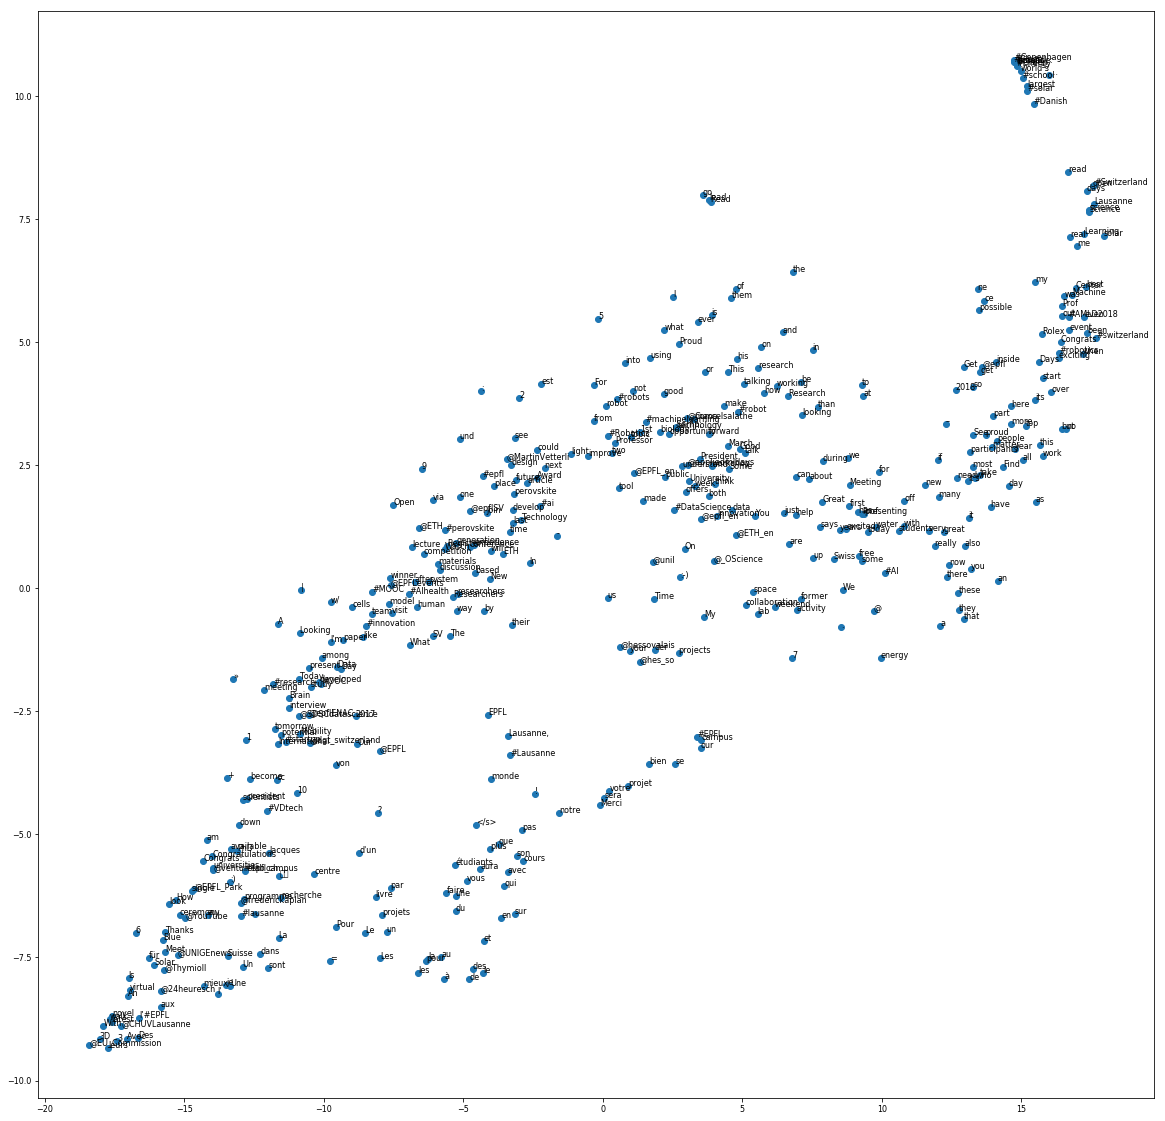

In [32]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(20, 20)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Question 1. a

Observe the plot of word embeddings. Do you observe any patterns?

Some patterns: <br>
Similar hashtags are clustered together due to same context word <br>
Artikels are clustered together <br>
Some Denmark related words in the upper right corner <br>
Mentions to schools are clustered together <br>


### Question 1. b

Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings.

Find the top 3 terms that are most similar to 'la', 'EPFL', '#robot', 'this', 

In [102]:
def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=3):
    term_embeddings_dict = {}
    for i,term in enumerate(vocabulary):
        term_embeddings_dict[term] = word_embeddings[i]
        
    if input_term not in term_embeddings_dict:
        return "Term not in the vocabulary"
    
    input_term_embedding = term_embeddings_dict[input_term]
    term_similarities = []
    for term, embedding in term_embeddings_dict.items():
        term_similarities.append([term, cosine_similarity(input_term_embedding.reshape((1,-1)), 
                                                          embedding.reshape((1,-1)))])
        
    sorted_terms = sorted(term_similarities, key = lambda x: -1 * x[1])[0:num_terms]
    
    return sorted_terms

find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)

# Note:
# cosine_similarity takes a matrix (of all word vectors) as input,
# so it's better not to loop through all terms to computer term_similarities for efficieny reasons
# I avoided doing this in this part for better readability, 
# although you will see matrix based solution in get_most_similar_documents
# in any case, you will never need to compute similarities by yourself, instead you can use:
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('model.vec')
# similar = model.most_similar(positive=['epfl'],topn=10)

[['EPFL', array([[1.]])],
 ['@EPFL', array([[0.9998869]])],
 ['#EPFL', array([[0.9998651]])],
 ['programme', array([[0.99980643]])],
 ['l’#EPFL', array([[0.99980149]])]]

### Question 1. c [Optional]
​
Download the text file using the following command:
​
> wget http://mattmahoney.net/dc/text8.zip -O text8.gz <br>
> tar -xvf text8.gz 
​
​
The above command creates a text file named 'text8'. Regenerate the fasttext embeddings using the text8 file. Plot the word embeddings for first 1000 terms in the vocabulary.
​
### Question 1. d [Optional]
​
Observe the word embeddings that are visualized in this link http://www.anthonygarvan.com/wordgalaxy/ . Can you make some interesting observations? 

## 2.  Basic Search Engine Using Word Embeddings



In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.

#### Do not forget to handle cases where a given word is not in the vocabulary!



In [4]:
# Loading of libraries and documents
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
from nltk.corpus import stopwords
import math
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

# Tokenize, stem a document
stemmer = PorterStemmer()
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()

# in case you use python 2.7 and there are decoding errors. well, do not use python 2.7
#with open("epfldocs.txt", "rb") as f:
#    contents = f.read().decode("UTF-8")
        
original_documents = [x.strip() for x in content] 
documents = [tokenize(d).split() for d in original_documents]



[nltk_data] Downloading package stopwords to /Users/elmas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/elmas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Question 2. a
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [24]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

In [30]:
def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in nltk.word_tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            print(index)
            continue
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 

### Question 2. b
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector. Are they seem to relevant?

In [106]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    tokens = query.split(' ')
    if(len(tokens) == 1):
        if(tokens[0] in vocabulary):
            return vector_dict[tokens[0]]
    elif(len(tokens) > 1):
        vlist = []
        for token in tokens:
            if (token in vocabulary):
                vlist.append(vector_dict[token])
        
        return aggregate_vector_list(vlist, aggfunc)
    else:
        print("%s is not in the vocabulary." % (query))
    
def get_most_similar_documents(query_vector, aggfunc, k = 5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None)
    indexes = indexes[0]
    return indexes


def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [119]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

@EPFL go to https://t.co/go0ZwhqT8d … … … … … … … … and read my campaign for the 2020 election
After jet lag, before forgetting: HK–CHIC, episode 6 @chic_community #epfl #voyage #hongkong https://t.co/3LNG5suuw8 …
"1946: No longer scared of the dark" His #CV is a gem https://t.co/H1TCmSsNJB … @unil @epfl @UNIGEnews @embl #Nobel https://t.co/YaFnD9cIOr
Pause déjeuner , moment de convivialité en plein coeur de #Portivechju avant de reprendre les travaux de l'AG de #Association des #EPFL https://t.co/NZhkFZTpxe
Bras de fer autour de la taxe d’études de l'#EPFL https://t.co/pr7GBU3f04
Et des super-pouvoirs des bibliothécaires de la BCU alors ? https://t.co/jOYiUOrOHe
Deux mois à Pyeongchang pour étudier la neige coréenne https://t.co/UWFtrbqvyH #epfl
J'ai inventé le mot #outrenoir pour dire au delà du noir #epfl #lausanne https://t.co/9Ck73apTXC
Rencontrez #pecub sur le stand de l'association #SavoirPatient au #salonsuissedelasante ! #patient #santé #lausanne #epfl https://t.co/Fhj9VLBQ5R


### Question 2. c
Compare the results with the vector space retrieval.


In [90]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    print(new_features.shape)
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [123]:
search_vec_sklearn("EPFL")

(1, 6938)
PostCarWorld | EPFL https://t.co/KfFQRJrQVb #epfl #epflcampus
Bluebrain | EPFL https://t.co/Y2S3hz1817 #epfl #epflcampus
Drone Days | EPFL https://t.co/ZdNwhb0EzL #epfl #epflcampus
Six EPFL startups are among the Swiss top 10 https://t.co/Re0xB2VBZ0 #epfl
Un Plan de mobilité « Made in EPFL » https://t.co/efcVQ215Nh #epfl
EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
EPFL students get hands-on experience with “Made in China” https://t.co/DKgMXia7tQ #epfl
Waiting for the ceremony to start! #epflalumnigala #epfl  @epfl https://t.co/ucZjZmNfYF
I see you @EPFL ! https://t.co/BxrHPaMqlX
@JimHarris EPFL's campus has the world's first solar window https://t.co/VNM71Za5m0 #epfl


### Question 2. d
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.

1. Use a bigger corpus
2. Try pretrained vectors (check glove)
3. Preprocess (lowercase, stem) (if the former 2 options are not available)
4. Use heuristics to find similar words and aggregate their vectors, i.e. get a word in the query's stem and the words that have the same stem, get the words with close edit distance to catch hashtags and mentions etc.
    Some examples:
    * MAGA -> What it stands for: Make America Great Again (What MAGA stands for)
    * MAGA -> Cooccuring words, i.e. TCOT (Top Conservatives on Twitter, likely precedes the slogan MAGA)
    * MAGA -> words of concept (Republican) = {Tcot, PJNET, Republic etc.} use the concept vector / average of the word vectors' belonging to that concept
    Use wordnet (https://wordnet.princeton.edu) but no MAGA unfortunately :(
5. Search the literature for more ideas.
